In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from astropy.io import fits
import pandas
from spectral_cube import SpectralCube
import plotly.express as px
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord

import warnings
warnings.filterwarnings('ignore')

In [50]:
Cube = SpectralCube.read('/home/scratch/hfwest/RAMPS/Data/L28_5_NH3_1-1_cube.fits') # Bring in spectral cube to obtain longitude, latitude, and V_LSR values from pixel values
v, y, x = Cube.world[:, :, :] # Extract wcs
x_eff = x.value
y_eff = y.value
v_eff = v.value

KeyboardInterrupt: 

In [ ]:
_28_5_data = pandas.read_csv('/users/hfwest/GBO-REU/Data/RAMPS_CLF/28_5.txt', sep = '\s+')
_28_5_data['l'] = np.zeros(shape=len(_28_5_data))
_28_5_data['b'] = np.zeros(shape=len(_28_5_data))
_28_5_data['V_LSR'] = np.zeros(shape=len(_28_5_data))
_28_5_data['ang_size'] = np.zeros(shape= len(_28_5_data))

bound_sky_low = pixel_to_skycoord(max(_28_5_data['x']), min(_28_5_data['y']), Cube.wcs) # Counter-intuitive min/max for l because left = positive
bound_sky_high = pixel_to_skycoord(min(_28_5_data['x']), max(_28_5_data['y']), Cube.wcs)
low_l = bound_sky_low.l.value
high_l = bound_sky_high.l.value
low_b = bound_sky_low.b.value
high_b = bound_sky_high.b.value

for idx in range(len(_28_5_data)):
    sky = pixel_to_skycoord(_28_5_data.iat[idx, 1], _28_5_data.iat[idx, 2], Cube.wcs) # Extract pixel values
    l_val = sky.l.value
    b_val = sky.b.value
    _28_5_data.iat[idx, 11] = l_val
    _28_5_data.iat[idx, 12] = b_val
    _28_5_data.iat[idx, 13] = v_eff[_28_5_data.iat[idx,3], _28_5_data.iat[idx, 2], _28_5_data.iat[idx, 1]]

    # Assume pixels in l and b are approximately equally sized
    pix_ang_size = (high_l - low_l)/Cube.shape[2]
    _28_5_data.iat[idx, 14] = _28_5_data.iat[idx, 7] * pix_ang_size * 60 # ang_size in arcmin, as in RAMPS catalog

_28_5_data = _28_5_data.drop(columns= ['Ncl', 'x', 'y', 'v', 'FWHMx', 'FWHMy', 'FWHMv', 'Npix', 'R']) # Remove extraneous columns including original pixel values
_28_5_data

,Tpeak,Sum(T),l,b,V_LSR,ang_size
0,3.58,2371.11,28.202502,-0.045833,95806.554609,0.790709
1,3.55,2249.01,28.569212,-0.239167,87839.273561,0.800693
2,3.51,2465.62,28.200835,-0.050833,96005.736636,0.798696
3,3.35,4170.72,28.564210,-0.234167,85648.271272,1.286899
4,3.30,2038.34,28.205834,0.017500,78278.536302,0.848615
...,...,...,...,...,...,...
576,0.29,1.25,28.819249,-0.315833,101582.833370,0.055909
577,0.28,2.48,28.897546,-0.234167,95408.190557,0.055909
578,0.28,2.81,28.650844,0.112500,64933.340546,0.055909
579,0.27,1.99,28.814208,-0.222500,98395.920950,0.055909


In [ ]:
RAMPS_data = pandas.read_csv('/users/hfwest/GBO-REU/Data/RAMPS_clump_catalog_diss_data.txt', sep = '\s+')
RAMPS_data['l'] = np.full(shape=len(RAMPS_data), fill_value= np.nan) # Create 'l' and 'b' columns
RAMPS_data['l'][0] = '(deg)'
RAMPS_data['b'] = np.full(shape=len(RAMPS_data), fill_value= np.nan)
RAMPS_data['b'][0] = '(deg)'
RAMPS_data['T_peak'] = np.full(shape=len(RAMPS_data), fill_value= np.nan)
RAMPS_data['T_peak'][0] = '(K)'

for idx in range(1, len(RAMPS_data)): # For each item, extract longitude and latitude from clump name
    l_val = float(RAMPS_data.iat[idx, 0][1:7])
    b_val = float(RAMPS_data.iat[idx, 0][7::]) # includes sign at index 7

    RAMPS_data.iat[idx, 26] = l_val
    RAMPS_data.iat[idx, 27] = b_val

    in_bounds = bool(low_l <= l_val <= high_l and low_b <= b_val <= high_b)

    if in_bounds:
        sky = SkyCoord(l=l_val, b=b_val, unit='deg', frame='galactic')
        x_pix, y_pix = skycoord_to_pixel(sky, Cube.wcs) # Extract pixel values

        x_pix = int(np.round(x_pix)) # Round pixel floats to nearest int and explicitly cast
        y_pix = int(np.round(y_pix))
        
        RAMPS_data.iat[idx, 28] = np.nanmax(Cube[:, y_pix, x_pix].value)

# Then remove extraneous columns, including the original clump name
RAMPS_data = RAMPS_data.drop(columns=['ClumpName', 'T_rot', 'log10(N_tot,ba)', 'p1', 'M_clump', 'L_clump', 'EvolState', 
                         'FILLER', 'FILLER.1', 'FILLER.2', 'T_rot_err','log10(N_tot,ba)_err', 'sigma_err', 
                         'V_LSR_err', 'chi(NH3)_err', 'd1_err', 'FILLER.3', 'M_clump_err', 'L_clump_err', 'FILLER.4'])

clipped_RAMPS_data = RAMPS_data[RAMPS_data['T_peak'].astype('str') != str(np.nan)]
clipped_RAMPS_data

,theta_maj,theta_min,sigma,V_LSR,chi(NH3),d1,l,b,T_peak
0,(arcmin),(arcmin),(km/s),(km/s),(unitless),(kpc),(deg),(deg),(K)
1580,1.3037147811695637,0.8945056313261187,0.270951599013,77.8700559107,NaN,4.31,28.004,0.154,0.976749
1581,2.0247768172817957,1.4422715967121762,0.485564194524,94.7360198422,3.26967016996e-08,8.27,28.008,-0.055,2.048993
1582,0.6708538478021357,0.44719201535197156,0.535924933119,27.9188434776,NaN,12.54,28.01,0.086,0.846017
1583,0.72803698038826,0.5384918959789012,0.311737084559,74.6577263554,NaN,4.3,28.03,0.095,0.728212
...,...,...,...,...,...,...,...,...,...
1753,1.2648320504508879,0.5385559272244163,0.655958505568,70.8978156943,NaN,4.32,28.93,0.126,0.518288
1754,2.256018197467341,0.7071241921225605,0.637583638077,71.815543183,NaN,4.33,28.949,0.105,0.477874
1755,1.565468924268452,1.0769089192957488,0.541863254258,95.9343427927,9.82023869528e-09,8.02,28.959,-0.205,0.49462
1756,0.9847246975230498,0.5001102667606593,0.414696197334,82.7139638297,NaN,4.44,28.965,0.261,0.648487


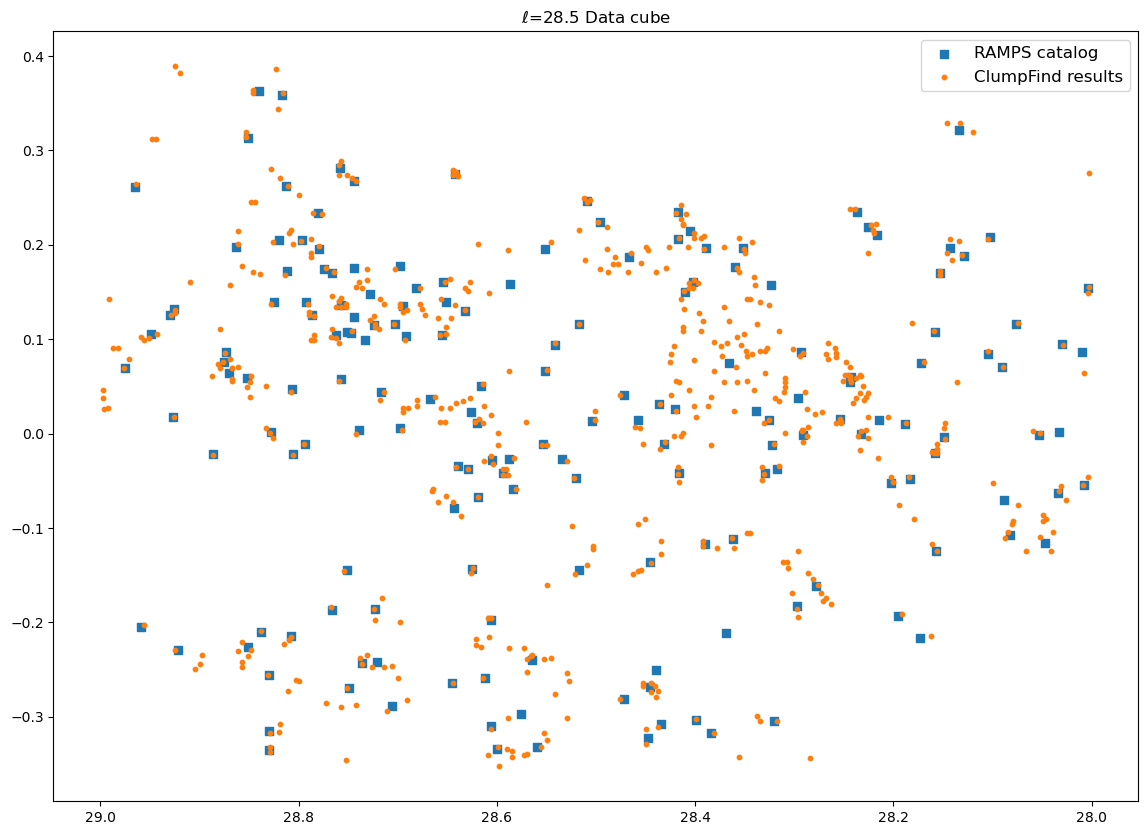

In [ ]:
clf_mask = _28_5_data['Tpeak'] >= min(clipped_RAMPS_data['T_peak'][1::])

# ClumpFit result mask: Peak temperature of clump is higher than lowest clump T_peak in original catalog

plt.figure(figsize= (14, 10))

# For size based on theta_maj:
# plt.scatter(clipped_RAMPS_data['l'][1::], clipped_RAMPS_data['b'][1::], marker='^', s=np.array(clipped_RAMPS_data['theta_maj'][1::].astype('float64'))*40, label= 'RAMPS catalog')

plt.scatter(clipped_RAMPS_data['l'][1::], clipped_RAMPS_data['b'][1::], marker='s', s= 30, label= 'RAMPS catalog')

# Only including clumps found to have peak T greater than lowest peak T in original catalog
# plt.scatter(_28_5_data['l'][clf_mask], _28_5_data['b'][clf_mask], s=25, label= 'ClumpFind results')

plt.scatter(_28_5_data['l'][clf_mask], _28_5_data['b'][clf_mask], s=10, label= 'ClumpFind results')

plt.title('$\ell$=28.5 Data cube')
plt.legend(fontsize='large')
plt.gca().invert_xaxis()
plt.show()

In [61]:
RAMPS_match = pandas.DataFrame(columns= clipped_RAMPS_data.columns)
CLF_match = pandas.DataFrame(columns= _28_5_data.columns)

for idx in range(1, len(clipped_RAMPS_data)):
    RAMPS_row = np.array(clipped_RAMPS_data.iloc[idx]).reshape(1, 9)
    CLF_row = None
    best_sep = np.inf

    c1 = SkyCoord(clipped_RAMPS_data.iat[idx, 6], clipped_RAMPS_data.iat[idx, 7], unit = 'deg', frame='galactic')
    r_ang = (float(clipped_RAMPS_data.iat[idx, 0]) + float(clipped_RAMPS_data.iat[idx, 1])) / 2

    for jdx in range(len(_28_5_data)):
        c2 = SkyCoord(_28_5_data.iat[jdx, 2], _28_5_data.iat[jdx, 3], unit = 'deg', frame='galactic')
        sep = c1.separation(c2).deg

        clf_ang = _28_5_data.iat[jdx, 5]

        if sep < min(r_ang, clf_ang) and sep < best_sep:
            CLF_row = np.array(_28_5_data.iloc[jdx]).reshape(1, 6)
            best_sep = sep
    if CLF_row.all() != None:
        RAMPS_match = pandas.concat([RAMPS_match, pandas.DataFrame(RAMPS_row, columns = RAMPS_match.columns)], axis= 0)
        CLF_match = pandas.concat([CLF_match, pandas.DataFrame(CLF_row, columns = _28_5_data.columns)], axis= 0)

In [62]:
RAMPS_match

,theta_maj,theta_min,sigma,V_LSR,chi(NH3),d1,l,b,T_peak
0,1.3037147811695637,0.8945056313261187,0.270951599013,77.8700559107,NaN,4.31,28.004,0.154,0.976749
0,2.0247768172817957,1.4422715967121762,0.485564194524,94.7360198422,3.26967016996e-08,8.27,28.008,-0.055,2.048993
0,0.6708538478021357,0.44719201535197156,0.535924933119,27.9188434776,NaN,12.54,28.01,0.086,0.846017
0,0.72803698038826,0.5384918959789012,0.311737084559,74.6577263554,NaN,4.3,28.03,0.095,0.728212
0,0.9219551393007873,0.5099014877988071,0.573025270011,100.074842081,NaN,8.27,28.033,0.002,0.646062
...,...,...,...,...,...,...,...,...,...
0,1.2648320504508879,0.5385559272244163,0.655958505568,70.8978156943,NaN,4.32,28.93,0.126,0.518288
0,2.256018197467341,0.7071241921225605,0.637583638077,71.815543183,NaN,4.33,28.949,0.105,0.477874
0,1.565468924268452,1.0769089192957488,0.541863254258,95.9343427927,9.82023869528e-09,8.02,28.959,-0.205,0.49462
0,0.9847246975230498,0.5001102667606593,0.414696197334,82.7139638297,NaN,4.44,28.965,0.261,0.648487


In [63]:
CLF_match

,Tpeak,Sum(T),l,b,V_LSR,ang_size
0,1.67,85.28,28.002517,0.155833,77880.172250,0.245599
0,2.36,829.33,28.009169,-0.054167,94810.644478,0.513162
0,0.77,12.48,28.029173,0.094167,74693.259831,0.125795
0,0.77,12.48,28.029173,0.094167,74693.259831,0.125795
0,0.76,4.57,28.052500,0.000833,99989.377160,0.055909
...,...,...,...,...,...,...
0,0.51,10.26,28.929180,0.125833,70908.801333,0.097840
0,0.55,39.72,28.950842,0.100833,72103.893490,0.258578
0,0.48,166.16,28.955868,-0.202500,96005.736636,0.440281
0,0.64,74.04,28.964226,0.264167,82660.540879,0.251589
